# Evaluation Metrics

Packages used : [scikit-learn](https://scikit-learn.org/stable/), [mb-scripts](https://pypi.org/project/mb-scripts/)<br>
Article Link : https://medium.com/@mr.sk12112002/evaluating-classification-models-943758b285be

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report,precision_recall_curve,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
mnist = fetch_openml("mnist_784")

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist.data.values,mnist.target.values

In [5]:
X.shape,y.shape

((70000, 784), (70000,))

In [6]:
y = y.astype(np.int32)

In [7]:
def view_some_image(X,y,r_size=28):
  random_index = np.random.randint(0,len(X))
  rand_img = X[random_index].reshape(r_size,r_size)
  plt.title(f"Number: {y[random_index]}",size=15)
  plt.imshow(rand_img,cmap="binary")
  plt.axis("off")

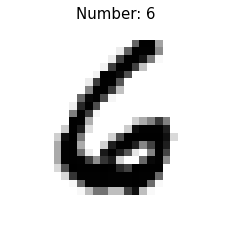

In [8]:
view_some_image(X,y)

In [9]:
!pip install mb_scripts

In [10]:
from mb_scripts.useful_scripts import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

# Training a binary classifier to begin with

In [11]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [12]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd = sgd.fit(X_train,y_train_5)

# Performance Measures
* Accuracy
* Confusion Matrix
* Precision, recall and precision_recall_curve
* ROC_curve

## Accuracy
Accuracy = Number of correct preds/Total number of test instances

One almost never uses this metric to choose a model but it is a good metric to start with.

In [13]:
from sklearn.model_selection import cross_val_score
from mb_scripts.metrics import accuracy_score
scores = cross_val_score(sgd,X_train,y_train_5,cv=5,scoring="accuracy")
accuracy_score(y_test_5,sgd.predict(X_test))

0.96

In [14]:
scores

array([0.93526786, 0.95491071, 0.96714286, 0.96571429, 0.96044643])

The cell below shows a case in which a model predicts as not 5.

In [15]:
accuracy_score(y_test_5,np.zeros(len(y_test_5)))

0.91

Getting more that 93.5% accuracy on all folds is a great thing. But a classifier which classifies everything as **not a 5** will have an accuracy of **90%** meaning that accuracy is not a metric that we should rely upon.<br>
The reason behind this is that the number of negative classes (in this case numbers other than 5) are larger in number compared to 5. Images of 5 constitute only about 10% of the dataset.<br>
Never use `accuracy` as a metric when it comes to **skewed** datasets

## Confusion Matrix
A confusion matrix is matrix that is made up of true positive(TP), true negative(TN), false positive(FP) and false negative(FN).<br>
The rows of the matrix represent the actual class while the columns represent the predicted class.<br>
The sum of rows gives the number of classes in the training dataset.<br>
For a good classifier, the any element other than the diagonal elements should be small (a value of 0 would indicate a perfect classifier which is almost never achievable when it comes to real world dataset)

In [16]:
from mb_scripts.metrics import confusion_matrix_binary
cls,conf_mat = confusion_matrix_binary(y_train_5,sgd.predict(X_train))

In [17]:
conf_mat

array([[49073.,  1879.],
       [  513.,  4535.]])

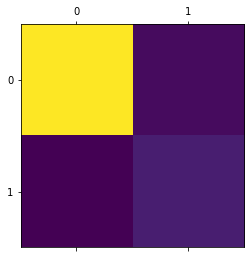

In [18]:
plt.matshow(conf_mat)

## Precision and recall
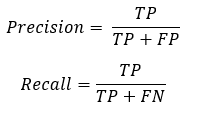

* Precision is the accuracy of positive predictions.
* Recall is the ratio of positives predicted correctly (also called true positive rate or sensitivity)<br>
Precision and recall give a true sense of our model is performing and where it is lagging.


In [19]:
pred = sgd.predict(X_train)

In [20]:
from mb_scripts.metrics import precision_binary,recall_binary
print(precision_binary(y_train_5,pred))
print(recall_binary(y_train_5,pred))

0.71
0.9


## F1-Score
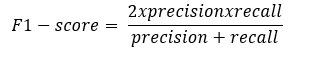

Having two metrics like precision and recall makes the process of comparing models a bit difficult. So, the **harmonic mean** of precision and recall is used to compare the models and it is called f1-score. It is a fairly good metric as it always favors the one that has a lower value. It will only have high value when both precision and recall are high.

In [21]:
from mb_scripts.metrics import f1_score
f1_score(y_train_5,pred)

0.79

The above value of 0.79 is a fair evaluation of our model as the is in line with confusion matrix

## Precision-Recall Trade off
When you try to increase either one of them the other goes down. This happens because most of the classifiers classify an instance based on a threshold. When you try to increase precision that is when you try to reduce the false positives you are pushing the threshold higher such that the positives predicted are always correct leading to a higher precision. But by doing this, a lot of positive instances are classified as negative leading to an increase in false negatives thereby reducing recall. The reverse happens when you try to increase recall, more false positives are produced leading to a decrease in precision score. 

In [22]:
sgd.decision_function(X_train[11:12])

array([-6710.66925762])

Let's assume the initial threshold to be 0. This threshold can be used to predict positive and negative instances thereby allowing us to create our own classification model

In [23]:
thresh = 0

In [24]:
y_train[-3]

5

In [25]:
sgd.decision_function(X_train[-3:-2]) > thresh

array([ True])

In [26]:
thresh = 10000
sgd.decision_function(X_train[-3:-2])>thresh

array([False])

By increasing the threshold we are decreasing the recall value

In [27]:
def plot_pr_with_threshold(precision,recall,threshold):
  sns.set_style("whitegrid")
  plt.plot(threshold,precision[:-1],'b-',label="Precision")
  plt.plot(threshold,recall[:-1],'r--',label="Recall")
  plt.legend()
  plt.xlabel("Threshold")

In [28]:
from sklearn.metrics import precision_recall_curve
y_scores = sgd.decision_function(X_train)
precision,recall,threshold = precision_recall_curve(y_train_5,y_scores)

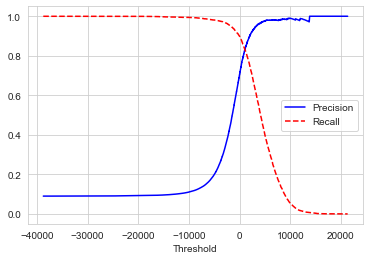

In [29]:
plot_pr_with_threshold(precision,recall,threshold)

As you can see from the above plot, one will always be lower when the other tends to go near 1

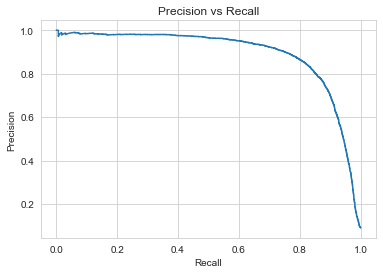

In [30]:
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall");

## ROC Curve
ROC (Reciever operator characteristic) curve is a plot b/w TPR and FPR. Here, TPR is also called recall or sensitivity and TNR is called as specifity. FPR is 1 - TNR. ROC curves are used to compare classification models a lot by measuring the area under the curve (AUC). The model which has the highest AUC is the best performing model

In [31]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,thresh = roc_curve(y_train_5,y_scores)

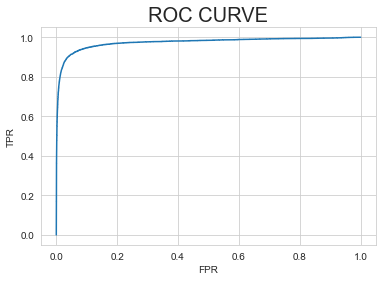

In [32]:
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE",size=20);